In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import numpy as np 
import pandas as pd 
import time
import random
from contextlib import contextmanager
from functools import partial
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pylab as plt
%matplotlib inline
import cv2
from tqdm.notebook import tqdm
import h5py
from skimage.transform import resize

!pip install SimpleITK
!pip install h5py

data_path = "/content/drive/MyDrive/CAM/LVEF/CAMUS/original_data/data/training/4ch/"

if os.path.exists(data_path):
    print(f"Path exists: {data_path}")
else:
    print(f"Path not found: {data_path}")

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

ROOT_PATH='/content/drive/MyDrive/CAM/LVEF/CAMUS/original_data/data/'
TRAIN_PATH=ROOT_PATH+'training/'
TEST_PATH=ROOT_PATH+'testing/'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Path exists: /content/drive/MyDrive/CAM/LVEF/CAMUS/original_data/data/training/4ch/


In [12]:
def data_norm(input):
    input = np.array(input, dtype=np.float32)
    input  = input - np.mean(input)
    output = input / (np.std(input) + 1e-12)
    return output

def mhd_to_array(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(path, sitk.sitkFloat32))

def read_info(data_file):
  info = {}
  with open(data_file, 'r') as f:
    for line in f.readlines():
      info_type, info_details = line.strip('\n').split(': ')
      info[info_type] = info_details
  return info

def plot_histogram(image, title):
    plt.figure()
    plt.hist(image.ravel(), bins=256)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

def plot_random_image_and_mask(image_folder, mask_folder, image_files, mask_files):
    index = random.randint(0, len(image_files) - 1)
    
    img_path = os.path.join(image_folder, image_files[index])
    mask_path = os.path.join(mask_folder, mask_files[index])
    
    img = sitk.GetArrayFromImage(sitk.ReadImage(img_path, sitk.sitkFloat32))
    mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path, sitk.sitkFloat32))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img[0], cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Image')
    ax[1].imshow(mask[0], cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Mask')
    plt.show()


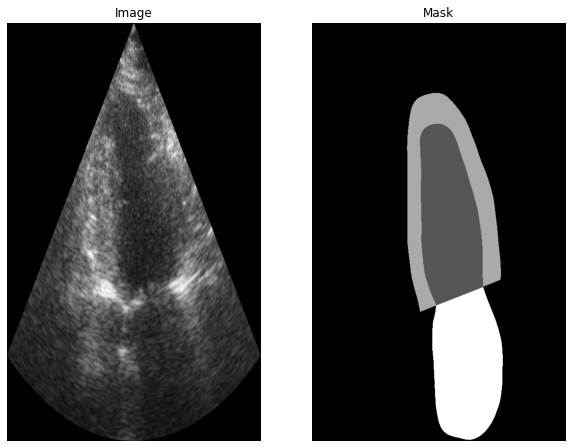

In [13]:
image_files = sorted([f for f in os.listdir(TRAIN_PATH + "4ch/frames") if f.endswith('.mhd')])
mask_files = sorted([f for f in os.listdir(TRAIN_PATH + "4ch/masks") if f.endswith('.mhd')])

plot_random_image_and_mask(TRAIN_PATH + "4ch/frames", TRAIN_PATH + "4ch/masks", image_files, mask_files)


In [14]:
widths = []
lengths = []
clst=['4ch']
for c in clst:
    file_list = os.listdir(os.path.join(TRAIN_PATH, c+"/frames"))
    for i in file_list:
        if "mhd" in i:
            path=TRAIN_PATH+c+"/frames/"+ i
            w = mhd_to_array(path).shape[2]
            l = mhd_to_array(path).shape[1]
            widths.append(w)
            lengths.append(l)
print('Max width : ',max(widths))
print('Min width : ',min(widths))
print('Max length : ',max(lengths))
print('Min length : ',min(lengths))


Max width :  1181
Min width :  323
Max length :  1945
Min length :  584


In [15]:
def resize_image(image, width, height):
    return resize(image, (height, width), preserve_range=True, mode='reflect', anti_aliasing=True)

def preprocess_images_and_masks(image_folder, mask_folder, width, height, image_files, mask_files):
    preprocessed_images = []
    preprocessed_masks = []

    for img_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files)):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        img = mhd_to_array(img_path)
        mask = mhd_to_array(mask_path)

        img_resized = np.zeros((img.shape[0], height, width), dtype=np.float32)
        mask_resized = np.zeros((mask.shape[0], height, width), dtype=np.float32)

        for i in range(img.shape[0]):
            img_resized[i] = resize_image(img[i], width, height)
            mask_resized[i] = resize_image(mask[i], width, height)

        img_normalized = data_norm(img_resized)

        preprocessed_images.append(img_normalized)
        preprocessed_masks.append(mask_resized)

    return preprocessed_images, preprocessed_masks


In [16]:
RESIZED_WIDTH = 256
RESIZED_LENGTH = 256
BATCH_SIZE = 8

image_files = sorted([f for f in os.listdir(TRAIN_PATH + "4ch/frames") if f.endswith('.mhd')])
mask_files = sorted([f for f in os.listdir(TRAIN_PATH + "4ch/masks") if f.endswith('.mhd')])

preprocessed_data_path = "/content/drive/MyDrive/CAM/CAM1/preprocessed_data/"

if not os.path.exists(preprocessed_data_path):
    os.makedirs(preprocessed_data_path)

for batch_start in range(0, len(image_files), BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, len(image_files))
    X_batch, y_batch = preprocess_images_and_masks(
        TRAIN_PATH + "4ch/frames", TRAIN_PATH + "4ch/masks",
        RESIZED_WIDTH, RESIZED_LENGTH,
        image_files[batch_start:batch_end], mask_files[batch_start:batch_end]
    )

    np.savez(
        preprocessed_data_path + f"preprocessed_data_batch_{batch_start}_{batch_end}.npz",
        X=X_batch, y=y_batch
    )


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]